<div style="font-family: Arial, Helvetica, sans-serif;">
    <div style="display: flex;padding-top: 20px">
        <div><strong>Course:</strong> Statistical Learning</div>
    </div>
    <div style="display: flex;padding-top: 20px">
        <div style="padding-right: 10px;"><strong>Class:</strong> 22CNTTh</div>
        <div></div>
    </div>
    <div style="display: flex;padding-top: 20px">
        <div style="padding-right: 10px;"><strong>Group:</strong> ...</div>
    </div>
    <div>
        <div style="display: flex;padding-top: 20px">
            <div style="padding-right: 10px;"><strong>Members:</strong></div>
            <div></div>
        </div>
        <table style="font-size: 15px; display:flex;padding-top: 20px">
            <tr>
                <th>No.</th>
                <th>Student ID</th>
                <th>Name</th>
            </tr>
            <tr>
                <td>1</td>
                <td> 22127004 </td>
                <td style="text-align:left;">Trình Cao An</td>
            </tr>
            <tr>
                <td>2</td>
                <td>22127014</td>
                <td style="text-align:left;">Nguyễn Kim Anh</td>
            </tr>
            <tr>
                <td>3</td>
                <td> 22127214 </td>
                <td style="text-align:left;">Võ Thị Kim Khôi</td>
            </tr>
        </table>
    </div>
    <div style="font-size: 25px ;font-weight: 800; text-align: center;padding-top: 20px;">FINAL PROJECT</div>
    <div style="font-size: 20px ;font-weight: 800; text-align: center;padding-top: 20px;">VIETNAMESE STOCKINSIGHT - MODEL FINTUNING (PROCESSING INPUT)</div>
</div>

# Mount Drive

In [ ]:
# Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

# VNCoreNLP

In [ ]:
!pip install py_vncorenlp

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.5 MB/s eta 0:00:00
  Created wheel for py_vncorenlp: filename=py_vncorenlp-0.1.4-py3-none-any.whl size=4304 sha256=3dc126b3427f87ff051ad8aceda9e054b14262a0d76deef3a99ea7c05757adf0
  Stored in directory: /root/.cache/pip/wheels/6d/2d/d6/158260bfd6820d144535857b80cc112bee5c3aa6d81b6dc049
Successfully built py_vncorenlp


In [ ]:
import py_vncorenlp
from collections import Counter
import os

Save files of VNCoreNLP

In [ ]:
# Tạo thư mục để lưu các file của VnCoreNLP
vncorenlp_dir = "/content/drive/MyDrive/statlearning/vncorenlp"
if not os.path.exists(vncorenlp_dir):
    os.makedirs(vncorenlp_dir)

Download model vncorenlp

In [ ]:
# Tải mô hình (chỉ cần chạy một lần)
# py_vncorenlp.download_model(save_dir=vncorenlp_dir)

Use segemtation model to split words (`wseg`). Remember to use the direct path to ensure the model work stably.

In [ ]:
# Nạp mô hình tách từ
# Đối với tác vụ này, chỉ cần bộ tách từ (wseg)
# Cung cấp đường dẫn tuyệt đối đến file.jar để đảm bảo hoạt động ổn định
rdrsegmenter = py_vncorenlp.VnCoreNLP(
    annotators=["wseg"],
    save_dir=vncorenlp_dir
)

Create a mapping between tokens and character positions in the original text
- Input:
  - `text`: original text
  - `tokens`: list of tokens from VNCoreNLP
- Output: list of tuples `(start_char, end_char)` for each token.

In [ ]:
def create_token_to_char_mapping(text, tokens):
    token_to_char = []
    current_pos = 0

    for token in tokens:
        # Find the position of the token in the original text starting from `current_pos`
        start_pos = text.find(token, current_pos)

        if start_pos == -1:
            # If the token is not found, it may be due to the token being altered
            # Try searching by ignoring whitespace
            clean_token = token.strip()
            start_pos = text.find(clean_token, current_pos)

            if start_pos == -1:
                # If still not found, assign the current position
                start_pos = current_pos
                end_pos = current_pos + len(token)
            else:
                end_pos = start_pos + len(clean_token)
        else:
            end_pos = start_pos + len(token)

        token_to_char.append((start_pos, end_pos))
        current_pos = end_pos

        # Skip whitespace
        while current_pos < len(text) and text[current_pos].isspace():
            current_pos += 1

    return token_to_char

Convert text and entity list to IOB2 format.
- Input:
  - `text`: the original text.
  - `entities`: list of entities with format {'text': str, 'type': str, 'start': int, 'end': int}.
  - `rdrsegmenter`: Loaded VnCoreNLP model

- Output: tuple: (tokens, labels) where tokens is the list of words and labels is the list of IOB2 tags.

In [ ]:
def convert_to_iob2(text, entities, rdrsegmenter):
    # Tokenize using VnCoreNLP and get the first sentence
    segmented = rdrsegmenter.word_segment(text)
    tokens = segmented[0]

    # Create a mapping from token to character coordinates
    token_to_char = create_token_to_char_mapping(text, tokens)

    # Initialize all labels as 'O'
    labels = ['O'] * len(tokens)

    for entity in entities:
        entity_start = entity['start']
        entity_end = entity['end']
        entity_type = entity['type']

        # Find tokens within the entity's range
        is_first_token = True
        for i, (token_start, token_end) in enumerate(token_to_char):
            # Check if tokens overlap with the entity
            if token_start < entity_end and token_end > entity_start:
                if is_first_token:
                    labels[i] = f'B-{entity_type}'
                    is_first_token = False
                else:
                    labels[i] = f'I-{entity_type}'

    return tokens, labels

Process JSONL file and convert to IOB2 format
- Input:
  - input_file (str): Path to the input JSONL file
  - output_file (str): Path to the output file
  - rdrsegmenter: Loaded VnCoreNLP model

In [ ]:
def process_jsonl_to_iob2(input_file, rdrsegmenter):
    processed_data = []

    with open(input_file, 'r', encoding='utf-8') as f:
        for line_num, line in enumerate(f, 1):
            try:
                # Parse JSON
                data = json.loads(line.strip())

                # Get text and entities
                text = data['text']
                entities = data['entities']

                # Convert to IOB2
                tokens, labels = convert_to_iob2(text, entities, rdrsegmenter)

                processed_data.append({
                    'tokens': tokens,
                    'labels': labels,
                    'original_text': text,
                    'source': data.get('source', '')
                })

                if line_num % 100 == 0:
                    print(f"Đã xử lý {line_num} dòng...")

            except Exception as e:
                print(f"Lỗi ở dòng {line_num}: {str(e)}")
                continue

    return processed_data

In [ ]:
input_file = '/content/drive/MyDrive/statlearning/data/cleaned_data_full.jsonl'
output_file = '/content/drive/MyDrive/statlearning/data/processed_iob2_data.jsonl'

processed_data = process_jsonl_to_iob2(input_file, rdrsegmenter)
with open(output_file, 'w', encoding='utf-8') as f:
    for data in processed_data:
        json.dump(data, f, ensure_ascii=False)
        f.write('\n')

print(f"Done! Save at: {output_file}")
print(f"Total processed data: {len(processed_data)}")

Đã xử lý 100 dòng...
Đã xử lý 200 dòng...
Đã xử lý 300 dòng...
Đã xử lý 400 dòng...
Đã xử lý 500 dòng...
Đã xử lý 600 dòng...
Đã xử lý 700 dòng...
Đã xử lý 800 dòng...
Đã xử lý 900 dòng...
Đã xử lý 1000 dòng...
Đã xử lý 1100 dòng...
Đã xử lý 1200 dòng...
Đã xử lý 1300 dòng...
Đã xử lý 1400 dòng...
Đã xử lý 1500 dòng...
Đã xử lý 1600 dòng...
Đã xử lý 1700 dòng...
Đã xử lý 1800 dòng...
Đã xử lý 1900 dòng...
Đã xử lý 2000 dòng...
Đã xử lý 2100 dòng...
Đã xử lý 2200 dòng...
Đã xử lý 2300 dòng...
Đã xử lý 2400 dòng...
Đã xử lý 2500 dòng...
Đã xử lý 2600 dòng...
Đã xử lý 2700 dòng...
Đã xử lý 2800 dòng...
Đã xử lý 2900 dòng...
Đã xử lý 3000 dòng...
Đã xử lý 3100 dòng...
Đã xử lý 3200 dòng...
Đã xử lý 3300 dòng...
Đã xử lý 3400 dòng...
Đã xử lý 3500 dòng...
Đã xử lý 3600 dòng...
Đã xử lý 3700 dòng...
Đã xử lý 3800 dòng...
Đã xử lý 3900 dòng...
Đã xử lý 4000 dòng...
Đã xử lý 4100 dòng...
Đã xử lý 4200 dòng...
Đã xử lý 4300 dòng...
Đã xử lý 4400 dòng...
Đã xử lý 4500 dòng...
Đã xử lý 4600 dòng.

## Analyze processed_data

General information of `processed_data`

In [ ]:
# Thông tin tổng quan về dữ liệu
print("=" * 80)
print("GENERAL INFORMATION ABOUT THE PROCESSED DATA")
print("=" * 80)

total_samples = len(processed_data)
total_tokens = sum(len(sample['tokens']) for sample in processed_data)
avg_tokens_per_sample = total_tokens / total_samples

print(f"📊 Total samples: {total_samples:,}")
print(f"🔤 Avg tokens: {total_tokens:,}")
print(f"📈 Avg tokens/sample: {avg_tokens_per_sample:.1f}")

GENERAL INFORMATION ABOUT THE PROCESSED DATA
📊 Total samples: 106,246
🔤 Avg tokens: 18,174,633
📈 Avg tokens/sample: 171.1


Length of token

In [ ]:
# Thống kê độ dài tokens
token_lengths = [len(sample['tokens']) for sample in processed_data]
print(f"📏 Length of tokens - Min: {min(token_lengths)}, Max: {max(token_lengths)}, Median: {np.median(token_lengths):.1f}")

📏 Length of tokens - Min: 4, Max: 990, Median: 175.0


Sample of data

In [ ]:
print("\n" + "=" * 50)
print("FIRST SAMPLE:")
print("=" * 50)
if processed_data:
    first_sample = processed_data[0]
    print(f"📝 Text: {first_sample['original_text'][:150]}...")
    print(f"🔗 Source: {first_sample['source']}")
    print(f"🔤 Number of tokens: {len(first_sample['tokens'])}")
    print(f"🏷️ Number of labels: {len(first_sample['labels'])}")

    print("\nFirst 10 tokens:")
    for i in range(min(10, len(first_sample['tokens']))):
        print(f"  {i+1:2d}. '{first_sample['tokens'][i]:15}' -> {first_sample['labels'][i]}")


FIRST SAMPLE:
📝 Text: Con gái bầu Đức gom bất thành 4 triệu cp HAG vì không xoay được tiền.Bà Đoàn Hoàng Anh, con gái ông Đoàn Nguyên Đức, không mua được bất kỳ cổ phiếu nà...
🔗 Source: https://vietstock.vn/2025/05/con-gai-bau-duc-gom-bat-thanh-4-trieu-cp-hag-vi-khong-xoay-duoc-tien-739-1309588.htm
🔤 Number of tokens: 235
🏷️ Number of labels: 235

First 10 tokens:
   1. 'C              ' -> O
   2. 'o              ' -> O
   3. 'n              ' -> O
   4. '               ' -> O
   5. 'g              ' -> O
   6. 'á              ' -> O
   7. 'i              ' -> O
   8. '               ' -> O
   9. 'b              ' -> O
  10. 'ầ              ' -> O


Analyzing all labels

In [ ]:
all_labels = []
entity_types = set()

for sample in processed_data:
    all_labels.extend(sample['labels'])

    # Get entity type
    for label in sample['labels']:
        if label != 'O':
            entity_type = label.split('-')[1]
            entity_types.add(entity_type)

label_counts = Counter(all_labels)

print("=" * 80)
print("STATISTIC OF IOB2")
print("=" * 80)

# Thống kê O vs Entity tokens
o_count = label_counts.get('O', 0)
entity_tokens = total_tokens - o_count

print(f"🔴 O (Outside): {o_count:,} tokens ({o_count/total_tokens*100:.1f}%)")
print(f"🟢 Entity tokens: {entity_tokens:,} tokens ({entity_tokens/total_tokens*100:.1f}%)")

print(f"\n📋 TYPE OF ENTITY USING TO REGCORNIZE:")
print("-" * 60)
for entity_type in sorted(entity_types):
    b_count = label_counts.get(f'B-{entity_type}', 0)
    i_count = label_counts.get(f'I-{entity_type}', 0)
    total_entity_tokens = b_count + i_count
    print(f"   • {entity_type:12}: {b_count:,} entities, {total_entity_tokens:,} tokens")

print(f"\n📊 ALL LABELS DETAIL:")
print("-" * 60)
for label in sorted(label_counts.keys()):
    count = label_counts[label]
    percentage = count/total_tokens*100
    print(f"   {label:15}: {count:,} ({percentage:.2f}%)")

STATISTIC OF IOB2
🔴 O (Outside): 17,677,333 tokens (97.3%)
🟢 Entity tokens: 497,300 tokens (2.7%)

📋 TYPE OF ENTITY USING TO REGCORNIZE:
------------------------------------------------------------
   • COMPANY     : 22,251 entities, 65,816 tokens
   • EVENT       : 2,158 entities, 6,196 tokens
   • FIN_IND     : 5,676 entities, 8,400 tokens
   • LAW         : 9 entities, 9 tokens
   • LOC         : 7,335 entities, 16,048 tokens
   • MBS         : 4 entities, 4 tokens
   • NUM         : 58,084 entities, 120,800 tokens
   • PERSON      : 2,504 entities, 5,983 tokens
   • PRICE_ACTION: 3,848 entities, 8,096 tokens
   • RISK        : 355 entities, 539 tokens
   • STOCK       : 66,729 entities, 130,267 tokens
   • STRATEGY    : 1,293 entities, 2,266 tokens
   • TIME        : 40,586 entities, 132,846 tokens
   • TITLE       : 9 entities, 30 tokens

📊 ALL LABELS DETAIL:
------------------------------------------------------------
   B-COMPANY      : 22,251 (0.12%)
   B-EVENT        : 2,158 (

### Visualization

Distribution of IOB2 labels: Proportion between O and Entity

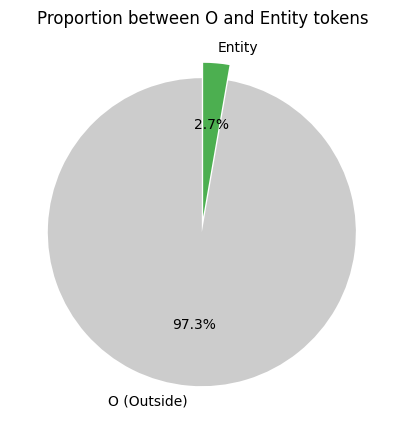

In [ ]:
labels_pie = ['O (Outside)', 'Entity']
sizes_pie = [o_count, entity_tokens]
colors = ['#cccccc', '#4caf50']

plt.figure(figsize=(5, 5))
plt.pie(sizes_pie, labels=labels_pie, autopct='%1.1f%%', startangle=90, colors=colors, explode=(0.05, 0.05))
plt.title('Proportion between O and Entity tokens')
plt.show()

Number of token per each type of entity

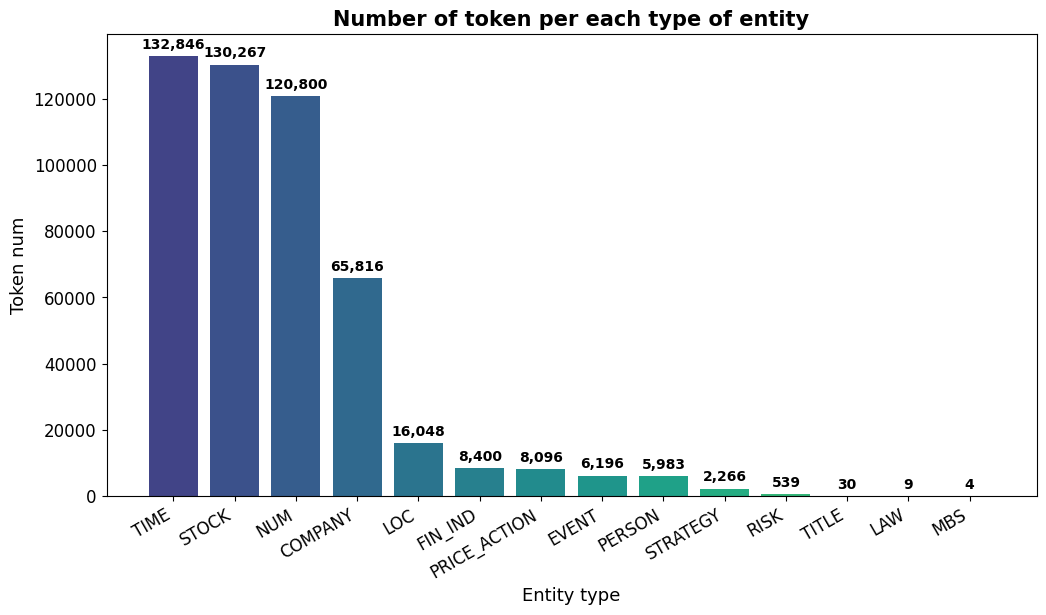

In [ ]:
entity_types_sorted = sorted(entity_types)
entity_token_counts = [
    label_counts.get(f'B-{etype}', 0) + label_counts.get(f'I-{etype}', 0)
    for etype in entity_types_sorted
]

# Sort descending
sorted_pairs = sorted(zip(entity_types_sorted, entity_token_counts), key=lambda x: x[1], reverse=True)
entity_types_sorted, entity_token_counts = zip(*sorted_pairs)

plt.figure(figsize=(12, 6))
bars = plt.bar(entity_types_sorted, entity_token_counts, color=plt.cm.viridis(np.linspace(0.2, 0.8, len(entity_types_sorted))))

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + max(entity_token_counts)*0.01, f'{height:,}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.ylabel('Token num', fontsize=13)
plt.xlabel('Entity type', fontsize=13)
plt.title('Number of token per each type of entity', fontsize=15, fontweight='bold')
plt.xticks(rotation=30, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Label vs. Token

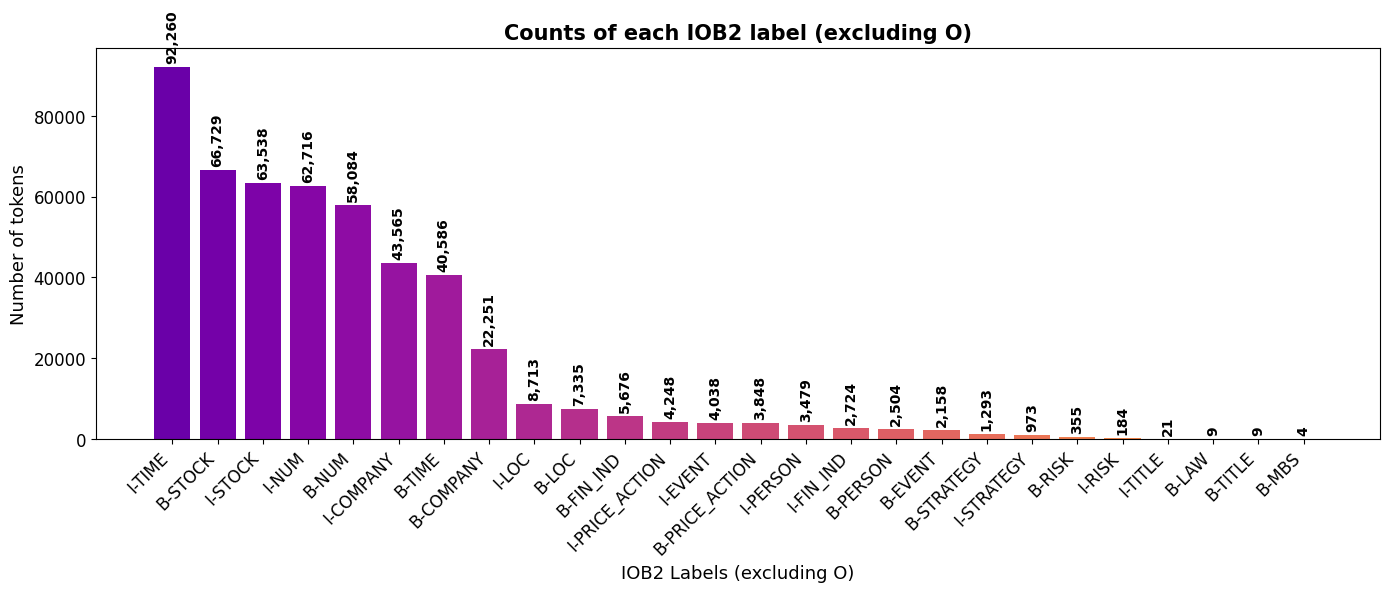

In [ ]:
# Remove the 'O' label to prevent misalignment (lệch trục)
entity_labels = [label for label in label_counts if label != 'O']
entity_counts = [label_counts[label] for label in entity_labels]

# Sort in descending order
sorted_pairs = sorted(zip(entity_labels, entity_counts), key=lambda x: x[1], reverse=True)
entity_labels_sorted, entity_counts_sorted = zip(*sorted_pairs)

plt.figure(figsize=(14, 6))
bars = plt.bar(entity_labels_sorted, entity_counts_sorted, color=plt.cm.plasma(np.linspace(0.2, 0.8, len(entity_labels_sorted))))

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + max(entity_counts_sorted)*0.01, f'{height:,}',
             ha='center', va='bottom', fontsize=10, fontweight='bold', rotation=90)

plt.ylabel('Number of tokens', fontsize=13)
plt.xlabel('IOB2 Labels (excluding O)', fontsize=13)
plt.title('Counts of each IOB2 label (excluding O)', fontsize=15, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Distribution of token lengths per sample

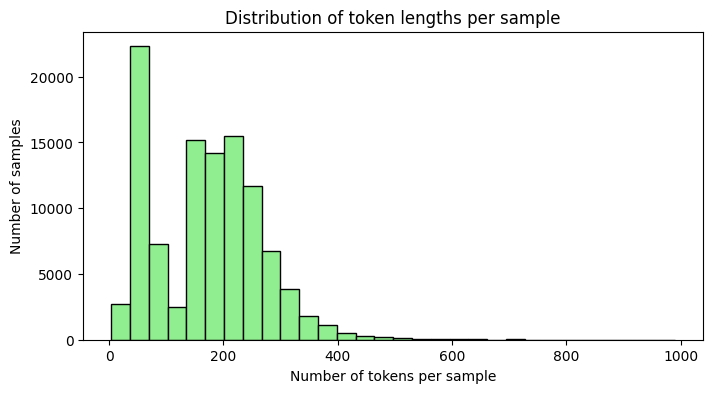

In [ ]:
token_lengths = [len(sample['tokens']) for sample in processed_data]

plt.figure(figsize=(8, 4))
plt.hist(token_lengths, bins=30, color='lightgreen', edgecolor='black')
plt.xlabel('Number of tokens per sample')
plt.ylabel('Number of samples')
plt.title('Distribution of token lengths per sample')
plt.show()

In [ ]:
with open('/content/drive/MyDrive/statlearning/data/processed_iob2_phobert.jsonl', 'w', encoding='utf-8') as f:
    for sample in processed_data:
        json.dump({
            'tokens': sample['tokens'],
            'ner_tags': sample['labels']
        }, f, ensure_ascii=False)
        f.write('\n')

print(f"Done")

Done


# Structuring Data with Hugging Face Datasets - `datasets`

## Import packages

In [ ]:
from datasets import Dataset, DatasetDict

In [ ]:
processed_data = []
with open('/content/drive/MyDrive/statlearning/data/processed_iob2_phobert.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        processed_data.append(json.loads(line.strip()))

# Check first 2 samples
for i, sample in enumerate(processed_data[:2]):
    print(f"Sample {i+1}:")
    print("Tokens:", sample['tokens'])
    print("NER tags:", sample['ner_tags'])
    print('-'*60)

Sample 1:
Tokens: Con gái bầu Đức gom bất_thành 4 triệu cp HAG vì không xoay được tiền.Bà Đoàn Hoàng_Anh , con gái ông Đoàn Nguyên Đức , không mua được bất_kỳ cổ_phiếu nào trong số 4 triệu cổ_phiếu HAG đăng_ký , do không thu_xếp được tài_chính cá_nhân .
NER tags: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

In [ ]:
# processed_data: {'tokens': [...], 'ner_tags': [...]}
full_dataset = Dataset.from_list(processed_data)

# Split the data into training, validation, and test sets: 8/1/1
train_test_split = full_dataset.train_test_split(test_size=0.2, seed=42)
test_val_split = train_test_split['test'].train_test_split(test_size=0.5, seed=42)

# Create a DatasetDict to organize the datasets conveniently
raw_datasets = DatasetDict({
    'train': train_test_split['train'],
    'validation': test_val_split['train'],
    'test': test_val_split['test']
})

raw_datasets

DatasetDict({
    train: Dataset({
        features: ['tokens', 'labels', 'original_text', 'source'],
        num_rows: 84996
    })
    validation: Dataset({
        features: ['tokens', 'labels', 'original_text', 'source'],
        num_rows: 10625
    })
    test: Dataset({
        features: ['tokens', 'labels', 'original_text', 'source'],
        num_rows: 10625
    })
})

Save `DatasetDict`

In [ ]:
save_path = "/content/drive/MyDrive/statlearning/data/ner_dataset_splits"

# Save to disk
raw_datasets.save_to_disk(save_path)
print(f"Done")

Saving the dataset (0/1 shards):   0%|          | 0/84996 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10625 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10625 [00:00<?, ? examples/s]

Done


# Load HuggingFace Dataset

Bắt buộc phải tải `fsspec`bản `2023.6.0` nếu không sẽ không sử dụng `load_from_disk` của HuggingFace được

In [ ]:
!pip install fsspec==2023.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2023.6.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64

In [ ]:
from datasets import load_from_disk

base_path = "/content/drive/MyDrive/statlearning/data/ner_dataset_splits"
train_dataset = load_from_disk(f"{base_path}/train")
test_dataset = load_from_disk(f"{base_path}/test")
valid_dataset = load_from_disk(f"{base_path}/validation")

reloaded_datasets = DatasetDict({
    "train": train_dataset,
    "validation": valid_dataset,
    "test": test_dataset
})

print(reloaded_datasets)

DatasetDict({
    train: Dataset({
        features: ['tokens', 'labels', 'original_text', 'source'],
        num_rows: 84996
    })
    validation: Dataset({
        features: ['tokens', 'labels', 'original_text', 'source'],
        num_rows: 10625
    })
    test: Dataset({
        features: ['tokens', 'labels', 'original_text', 'source'],
        num_rows: 10625
    })
})


# Tokenize with PhoBERT

In [ ]:
from collections import Counter

Get all labels and sort them

In [ ]:
def get_all_labels(ds):
    counter = Counter()
    for split in ds:
        counter.update(label for example in ds[split] for label in example["labels"])
    return sorted(counter.keys())

In [ ]:
label_list = get_all_labels(reloaded_datasets)
label_list

['B-COMPANY',
 'B-EVENT',
 'B-FIN_IND',
 'B-LAW',
 'B-LOC',
 'B-MBS',
 'B-NUM',
 'B-PERSON',
 'B-PRICE_ACTION',
 'B-RISK',
 'B-STOCK',
 'B-STRATEGY',
 'B-TIME',
 'B-TITLE',
 'I-COMPANY',
 'I-EVENT',
 'I-FIN_IND',
 'I-LOC',
 'I-NUM',
 'I-PERSON',
 'I-PRICE_ACTION',
 'I-RISK',
 'I-STOCK',
 'I-STRATEGY',
 'I-TIME',
 'I-TITLE',
 'O']

In [ ]:
def sort_label_list_BIO(label_list):
  BI_pairs = []
  seen_i = set()
  for label in label_list:
    if label.startswith("B-"):
      entity = label[2:]
      i_label = f"I-{entity}"
      BI_pairs.append((label, i_label))
      seen_i.add(i_label)

  rest = [label for label in label_list if not label.startswith("B-") and label not in seen_i]

  sorted_list = []
  for b, i in sorted(BI_pairs):
    sorted_list.append(b)
    if i:
      sorted_list.append(i)
  sorted_list.extend(sorted(rest))

  return sorted_list

In [ ]:
expanded_labels = sort_label_list_BIO(label_list)
print(expanded_labels)

['B-COMPANY', 'I-COMPANY', 'B-EVENT', 'I-EVENT', 'B-FIN_IND', 'I-FIN_IND', 'B-LAW', 'I-LAW', 'B-LOC', 'I-LOC', 'B-MBS', 'I-MBS', 'B-NUM', 'I-NUM', 'B-PERSON', 'I-PERSON', 'B-PRICE_ACTION', 'I-PRICE_ACTION', 'B-RISK', 'I-RISK', 'B-STOCK', 'I-STOCK', 'B-STRATEGY', 'I-STRATEGY', 'B-TIME', 'I-TIME', 'B-TITLE', 'I-TITLE', 'O']


Map labels to labels_id

In [ ]:
label2id = {label: i for i, label in enumerate(expanded_labels)}
id2label = {i: label for label, i in label2id.items()}

def add_labels_id(batch):
    batch["labels_id"] = [
        [label2id[label] for label in labels] for labels in batch["labels"]
    ]
    return batch

updated_datasets = reloaded_datasets.map(add_labels_id, batched=True)

for idx in range(len(label2id)):
    label = [k for k, v in label2id.items() if v == idx][0]
    print(f"{idx}: {label}")

Map:   0%|          | 0/84996 [00:00<?, ? examples/s]

Map:   0%|          | 0/10625 [00:00<?, ? examples/s]

Map:   0%|          | 0/10625 [00:00<?, ? examples/s]

0: B-COMPANY
1: I-COMPANY
2: B-EVENT
3: I-EVENT
4: B-FIN_IND
5: I-FIN_IND
6: B-LAW
7: I-LAW
8: B-LOC
9: I-LOC
10: B-MBS
11: I-MBS
12: B-NUM
13: I-NUM
14: B-PERSON
15: I-PERSON
16: B-PRICE_ACTION
17: I-PRICE_ACTION
18: B-RISK
19: I-RISK
20: B-STOCK
21: I-STOCK
22: B-STRATEGY
23: I-STRATEGY
24: B-TIME
25: I-TIME
26: B-TITLE
27: I-TITLE
28: O


Tokenization and align the label for each token

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2", use_fast=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
def shift_label(label_id, id2label):
  label_name = id2label[label_id]
  if label_name.startswith("B-"):
    return label_id + 1
  return label_id

def tokenize_and_align_labels_phobert(example):
  labels = example["labels_id"]
  tokens = example["tokens"]

  tokenized = tokenizer(example["tokens"], is_split_into_words=True, truncation=True, max_length = 256)

  aligned_labels = []
  word_length = 0
  word_start = 0
  label = -100
  new_word = True

  for token in tokenized.input_ids:
    sub_word = tokenizer.convert_ids_to_tokens(token)

    if sub_word in ["<s>", "</s>"]:
      aligned_labels.append(-100)
      continue

    if word_start >= len(labels):
      continue

    # Đếm độ dài subword không tính dấu @@
    subword_clean = sub_word.replace("@@", "")
    length = len(subword_clean)

    # Một từ dài
    if sub_word.endswith("@@"):
      if not new_word: # token giữa
        aligned_labels.append(shift_label(labels[word_start], id2label))
      else: # token đầu
        aligned_labels.append(labels[word_start])
      word_length += length

    else:
      if word_start < len(labels):
        if not new_word: # token cuối
          aligned_labels.append(shift_label(labels[word_start], id2label))
        else: # từ đứng riêng
          aligned_labels.append(labels[word_start])

        word_length = word_length + length + 1
        word_start += word_length
        if word_start > len(labels)-1:
          word_start -= 1
        word_length = 0

    new_word = not sub_word.endswith("@@")

  tokenized["labels"] = aligned_labels
  return tokenized

In [ ]:
tokenized_datasets = updated_datasets.map(tokenize_and_align_labels_phobert, batched=False)
print(tokenized_datasets)

Map:   0%|          | 0/84996 [00:00<?, ? examples/s]

Map:   0%|          | 0/10625 [00:00<?, ? examples/s]

Map:   0%|          | 0/10625 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'labels', 'original_text', 'source', 'labels_id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 84996
    })
    validation: Dataset({
        features: ['tokens', 'labels', 'original_text', 'source', 'labels_id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10625
    })
    test: Dataset({
        features: ['tokens', 'labels', 'original_text', 'source', 'labels_id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10625
    })
})


In [ ]:
def print_tokens_labels_from_tokenized_dataset(dataset, tokenizer, n):
    for i in range(n):
        sample = dataset[i]
        input_ids = sample["input_ids"]
        labels = sample["labels"]

        tokens = tokenizer.convert_ids_to_tokens(input_ids)

        print(f"\nSample {i}:")
        print(f"{'Token':15} | Label")
        print("-" * 25)

        for token, label in zip(tokens, labels):
            print(f"{token:15} | {label}")

print_tokens_labels_from_tokenized_dataset(tokenized_datasets["train"], tokenizer, n=4)


Sample 0:
Token           | Label
-------------------------
<s>             | -100
Nhóm            | 28
có              | 28
liên_quan       | 28
đến             | 28
Bes@@           | 28
ton             | 28
tăng            | 28
sở_hữu          | 28
tại             | 28
VIB             | 20
lên             | 28
hơn             | 28
8%              | 12
.               | 28
</s>            | -100

Sample 1:
Token           | Label
-------------------------
<s>             | -100
Lãnh_đạo        | 28
May_@@          | 20
Sông_@@         | 21
Hồng            | 21
muốn            | 28
rút             | 28
sạch            | 28
vốn             | 28
sau             | 28
khi             | 28
cổ_phiếu        | 28
lập             | 28
đ@@             | 28
ỉ@@             | 28
nh.@@           | 28
Thành           | 28
viên            | 28
HĐQT            | 28
CTCP            | 28
May_@@          | 28
Sông_@@         | 28
Hồng            | 28
(               | 28
HOSE            | 28
:          

In [ ]:
from datasets import DatasetDict

save_path = "/content/drive/MyDrive/statlearning/phobert_tokenized_datasets"

tokenized_datasets.save_to_disk(save_path)

Saving the dataset (0/2 shards):   0%|          | 0/84996 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10625 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10625 [00:00<?, ? examples/s]

## Label distribution

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

label_counter = Counter()
for example in tokenized_datasets["train"]:
    for label_id in example["labels"]:
        if label_id != -100:
            label_counter[id2label[label_id]] += 1

entity_labels = [label for label in label_counter if label != 'O']
entity_counts = [label_counter[label] for label in entity_labels]

sorted_pairs = sorted(zip(entity_labels, entity_counts), key=lambda x: x[1], reverse=True)
entity_labels_sorted, entity_token_counts = zip(*sorted_pairs)

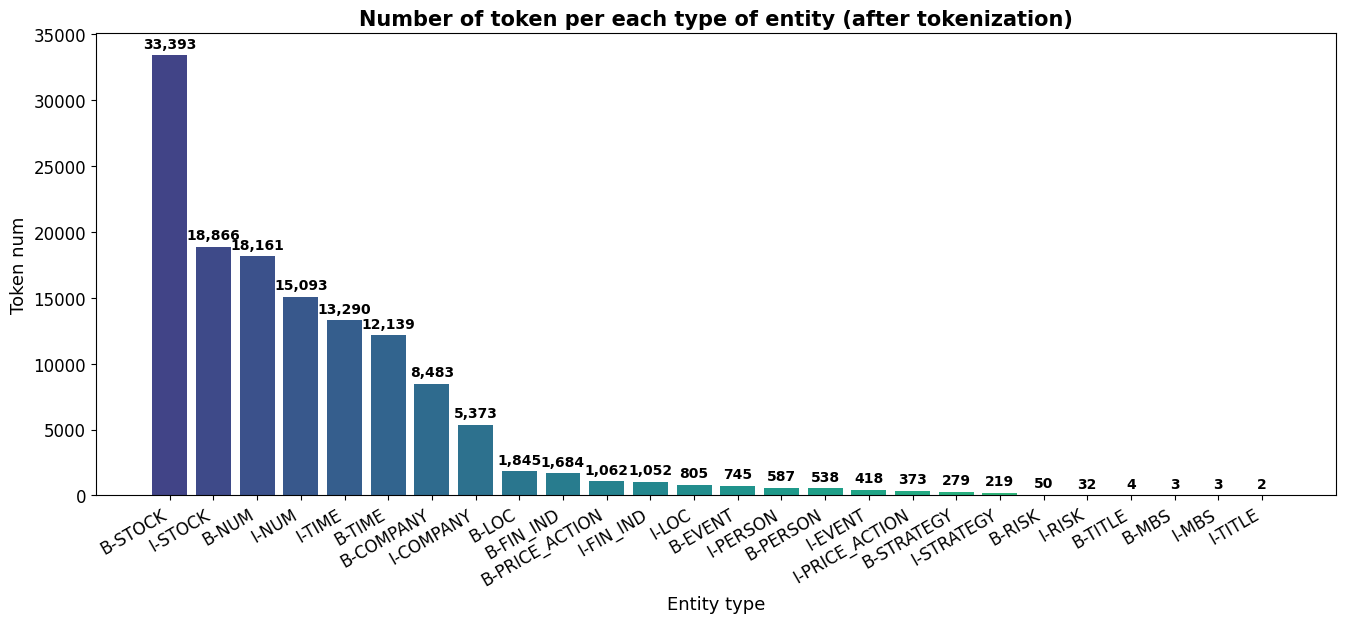

In [ ]:
plt.figure(figsize=(16, 6))
bars = plt.bar(entity_labels_sorted, entity_token_counts, color=plt.cm.viridis(np.linspace(0.2, 0.8, len(entity_labels_sorted))))
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + max(entity_token_counts)*0.01, f'{height:,}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.ylabel('Token num', fontsize=13)
plt.xlabel('Entity type', fontsize=13)
plt.title('Number of token per each type of entity (after tokenization)', fontsize=15, fontweight='bold')
plt.xticks(rotation=30, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Type of entity

In [ ]:
entity_type_counter = Counter()
for example in tokenized_datasets["train"]:
    for label_id in example["labels"]:
        if label_id != -100:
            label = id2label[label_id]
            if label != 'O':
                entity_type = label.split('-')[1]
                entity_type_counter[entity_type] += 1

entity_types_sorted, entity_token_counts = zip(*sorted(entity_type_counter.items(), key=lambda x: x[1], reverse=True))

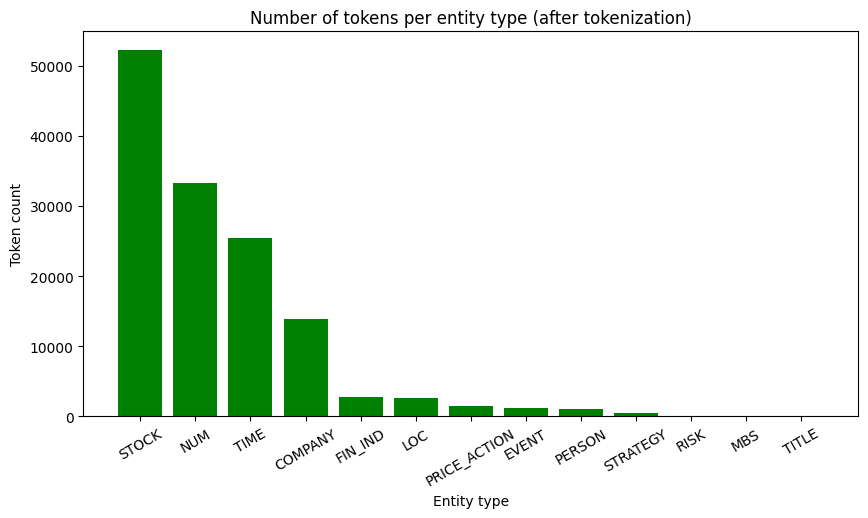

In [ ]:
plt.figure(figsize=(10,5))
bars = plt.bar(entity_types_sorted, entity_token_counts, color='green')
plt.xticks(rotation=30)
plt.title('Number of tokens per entity type (after tokenization)')
plt.ylabel('Token count')
plt.xlabel('Entity type')
plt.show()

In [ ]:
# In top 5 entity type
print("Top 5 entity types:")
for etype, count in list(zip(entity_types_sorted, entity_token_counts))[:5]:
    print(f"{etype}: {count}")

# In bottom 5 entity type
print("\nBottom 5 entity types:")
for etype, count in list(zip(entity_types_sorted, entity_token_counts))[-5:]:
    print(f"{etype}: {count}")

Top 5 entity types:
STOCK: 52259
NUM: 33254
TIME: 25429
COMPANY: 13856
FIN_IND: 2736

Bottom 5 entity types:
PERSON: 1125
STRATEGY: 498
RISK: 82
MBS: 6
TITLE: 6
